In [2]:
import pandas as pd
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from torch.nn.functional import softmax
import matplotlib.pyplot as plt
import scipy.stats as stats
import seaborn as sns
import numpy as np
import random
import math
from sklearn.datasets import make_blobs, make_moons
from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import silhouette_score
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import statsmodels.api as sm
%matplotlib inline

/Applications/anaconda3/envs/ada/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
sns.set_theme()

In [4]:
import os

In [5]:
os.getcwd()

'/Users/kilianwan/GitHub/ada-2024-project-pdfromscratch/src/workspaces'

In [43]:
df_ba_beers     = pd.read_csv('../data/beer_advocate/beers.csv')
df_ba_users     = pd.read_csv('../data/beer_advocate/users.csv')
df_ba_ratings   = pd.read_csv('../data/beer_advocate/ratings.csv')
df_regions      = pd.read_csv('../data/regions.csv')

In [4]:
df_ba_ratings.columns

Index(['user_id', 'beer_id', 'brewery_id', 'date', 'review', 'rating',
       'overall', 'aroma', 'appearance', 'palate', 'taste', 'text',
       'user_past_ratings_count', 'user_past_ratings_average',
       'beer_past_ratings_count', 'beer_past_ratings_average',
       'beer_global_style', 'user_beer_style_past_ratings_count',
       'user_beer_style_past_ratings_average', 'gini_impurity'],
      dtype='object')

In [6]:
df_ba_ratings.head()

,user_id,beer_id,brewery_id,date,review,rating,overall,aroma,appearance,palate,taste,text,user_past_ratings_count,user_past_ratings_average,beer_past_ratings_count,beer_past_ratings_average,beer_global_style,user_beer_style_past_ratings_count,user_beer_style_past_ratings_average,gini_impurity
0,nmann08.184925,142544,37262,1440064800,True,2.88,3.0,2.75,3.25,3.25,2.75,"From a bottle, pours a piss yellow color with ...",5915,3.742926,0,NaN,Pale Lager,324,3.183796,0.947660
1,stjamesgate.163714,19590,10093,1235127600,True,3.67,3.5,3.50,3.00,3.50,4.00,Pours pale copper with a thin head that quickl...,27,3.788148,3,3.903333,Pale Ale,4,3.765000,0.881834
2,mdagnew.19527,19590,10093,1142247600,True,3.73,3.5,3.50,4.00,3.50,4.00,"500ml Bottle bought from The Vintage, Antrim.....",133,4.017068,2,3.990000,Pale Ale,30,4.018667,0.952044
3,helloloser12345.10867,19590,10093,1101898800,True,3.98,4.5,3.50,4.00,4.00,4.00,Serving: 500ml brown bottlePour: Good head wit...,1,3.650000,1,4.000000,Pale Ale,2,3.815000,0.000000
4,cypressbob.3708,19590,10093,1093860000,True,4.00,4.0,4.00,4.00,4.00,4.00,"500ml bottlePours with a light, slightly hazy ...",168,3.229583,0,NaN,Pale Ale,44,3.501818,0.837813


In [7]:
df_ba_ratings_filtered = df_ba_ratings.dropna(subset=['user_beer_style_past_ratings_average', 'beer_past_ratings_average'])
X = df_ba_ratings_filtered[['user_beer_style_past_ratings_average', 'beer_past_ratings_average']]
y = df_ba_ratings_filtered['rating']

In [8]:
len(X)

8145050

In [9]:
len(y)

8145050

In [10]:
reg = sm.OLS(y, X).fit()

In [11]:
reg.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                 rating   R-squared (uncentered):                   0.989
Model:                            OLS   Adj. R-squared (uncentered):              0.989
Method:                 Least Squares   F-statistic:                          3.778e+08
Date:                Sun, 01 Dec 2024   Prob (F-statistic):                        0.00
Time:                        11:59:18   Log-Likelihood:                     -4.2239e+06
No. Observations:             8145050   AIC:                                  8.448e+06
Df Residuals:                 8145048   BIC:                                  8.448e+06
Df Model:                           2                                                  
Covariance Type:            nonrobust                                                  
========================================================================================================
                                           coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------
user_beer_style_past_ratings_average     0.5448      0.000   1623.609      0.000       0.544       0.545
beer_past_ratings_average                0.4557      0.000   1365.887      0.000       0.455       0.456
==============================================================================
Omnibus:                  1649292.337   Durbin-Watson:                   1.758
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          6032645.629
Skew:                          -0.991   Prob(JB):                         0.00
Kurtosis:                       6.721   Cond. No.                         18.4
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

## Interpretation

- We get a high $R^2$ ($0.987$). This indicates that the model explains $98.7\%$ of the variance in `rating`. This suggests a strong linear relationship between the predictors and the dependent variable.
- Coefficients: 
    - `user_past_ratings_average` has a coefficient of $0.2163$. So for every 1-unit increase in `user_past_ratings_average`, `rating` increases by $0.216$ (when we hold `beer_past_ratings_average` constant)
    - `beer_past_ratings_average`: has a coefficient of $0.7816$. so for every 1-unit increase in `beer_past_ratings_average`, `rating` increases by $0.782$ (when we hold `user_past_ratings_average` constant).
- $p$-values : we get for both predictors a $p$-value of zero, meaning that their coefficients are highly statistically significant. So they are both strong predictors of the `rating`.
- $F$-statistic: we get an extremely high value ($\texttt{3.015e+08}$), and with its corresponding $p$-value (0) we get that at least one of the predictors contributes meaningfully to the `rating`.

# CHANGE

## Improve the model?

Now we can for example add the interaction term to see whether their combined effect significantly impacts `rating`. We will then look at the residuals to see if there is any linear relationship, and/or outliers/heteroskedasticity. In the case where we find nonlinear models (when residuals show symmetric patterns), we will consider a polynomial regression for example

In [50]:
from sklearn.preprocessing import PolynomialFeatures

In [51]:
interaction_term = PolynomialFeatures(interaction_only=True, include_bias=False)
interaction_term.fit_transform(X)

array([[ 3.78814815,  3.90333333, 14.78640494],
       [ 4.01706767,  3.99      , 16.0281    ],
       [ 3.65      ,  4.        , 14.6       ],
       ...,
       [ 3.81806452,  2.17      ,  8.2852    ],
       [ 3.75364929,  1.54      ,  5.78061991],
       [ 2.78571429,  3.        ,  8.35714286]])

In [12]:
X['interaction'] = X['user_beer_style_past_ratings_average'] * X['beer_past_ratings_average']

/var/folders/g1/hq_ymt617dz0gqxr47f1v5p40000gn/T/ipykernel_20734/3453452905.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['interaction'] = X['user_beer_style_past_ratings_average'] * X['beer_past_ratings_average']


In [13]:
reg_inter = sm.OLS(y,X).fit()

In [14]:
reg_inter.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                 rating   R-squared (uncentered):                   0.990
Model:                            OLS   Adj. R-squared (uncentered):              0.990
Method:                 Least Squares   F-statistic:                          2.647e+08
Date:                Sun, 01 Dec 2024   Prob (F-statistic):                        0.00
Time:                        11:59:28   Log-Likelihood:                     -4.0232e+06
No. Observations:             8145050   AIC:                                  8.046e+06
Df Residuals:                 8145047   BIC:                                  8.046e+06
Df Model:                           3                                                  
Covariance Type:            nonrobust                                                  
========================================================================================================
                                           coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------
user_beer_style_past_ratings_average     0.4035      0.000   1022.498      0.000       0.403       0.404
beer_past_ratings_average                0.3378      0.000    903.349      0.000       0.337       0.338
interaction                              0.0655      0.000    641.360      0.000       0.065       0.066
==============================================================================
Omnibus:                  1372507.787   Durbin-Watson:                   1.821
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          5975822.530
Skew:                          -0.774   Prob(JB):                         0.00
Kurtosis:                       6.900   Cond. No.                         54.9
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

## Interpretation

- We get the same $R^2$ ($0.987$), and the $R_{\text{adj}}^2$ is the same, so we have no penalty by adding the interaction term.
- Coefficients: 
    - `user_past_ratings_average` has a coefficient of $0.1375$. Which is less than before (**interpret more**) So for every 1-unit increase in `user_past_ratings_average`, `rating` increases by $0.1375$ (when we hold `beer_past_ratings_average` constant)
    - `beer_past_ratings_average`: has a coefficient of $0.6170$. Again less than before (**interpret more**) so for every 1-unit increase in `beer_past_ratings_average`, `rating` increases by $0.6170$ (when we hold `user_past_ratings_average` constant).
    - `user_past_ratings_average:beer_past_ratings_average` has a coefficient of $0.0623$ and a $p$-value of zero, showing that the interaction term is statistically significant
- $p$-values : we get for both predictors a $p$-value of zero, meaning that their coefficients are highly statistically significant. So they are both strong predictors of the `rating`.
- $F$-statistic: we get an extremely high value ($\texttt{3.015e+08}$), and with its corresponding $p$-value (0) we get that at least one of the predictors contributes meaningfully to the `rating`.

# CHANGE

In [15]:
df_ba_ratings.head()

,user_id,beer_id,brewery_id,date,review,rating,overall,aroma,appearance,palate,taste,text,user_past_ratings_count,user_past_ratings_average,beer_past_ratings_count,beer_past_ratings_average,beer_global_style,user_beer_style_past_ratings_count,user_beer_style_past_ratings_average,gini_impurity
0,nmann08.184925,142544,37262,1440064800,True,2.88,3.0,2.75,3.25,3.25,2.75,"From a bottle, pours a piss yellow color with ...",5915,3.742926,0,NaN,Pale Lager,324,3.183796,0.947660
1,stjamesgate.163714,19590,10093,1235127600,True,3.67,3.5,3.50,3.00,3.50,4.00,Pours pale copper with a thin head that quickl...,27,3.788148,3,3.903333,Pale Ale,4,3.765000,0.881834
2,mdagnew.19527,19590,10093,1142247600,True,3.73,3.5,3.50,4.00,3.50,4.00,"500ml Bottle bought from The Vintage, Antrim.....",133,4.017068,2,3.990000,Pale Ale,30,4.018667,0.952044
3,helloloser12345.10867,19590,10093,1101898800,True,3.98,4.5,3.50,4.00,4.00,4.00,Serving: 500ml brown bottlePour: Good head wit...,1,3.650000,1,4.000000,Pale Ale,2,3.815000,0.000000
4,cypressbob.3708,19590,10093,1093860000,True,4.00,4.0,4.00,4.00,4.00,4.00,"500ml bottlePours with a light, slightly hazy ...",168,3.229583,0,NaN,Pale Ale,44,3.501818,0.837813


In [16]:
df_ba_ratings_grouped = df_ba_ratings_filtered.groupby('beer_global_style')

In [17]:
len(df_ba_ratings_grouped)

15

In [18]:
def summary_per_style(df, style_column, independents, dependent):
    results = []
    
    grouped_data = df.groupby(style_column)
    
    for style, group in grouped_data:
        group = group.dropna(subset=independents + [dependent])
        
        if group.empty:
            continue
        X = group[independents].copy()
        # maybe add interaction but we will see depending on results
        X = sm.add_constant(X)
        y = group[dependent]
        
        model = sm.OLS(y, X).fit()
        
        result = {
            'Style': style,
            'R^2': model.rsquared,
            '| Coeff: const': model.params.get('const', None),
            '| Coeff: User per beer Past Ratings (avg)': model.params.get(independents[0], None),
            '| Coeff: Beer Past Ratings (avg)': model.params.get(independents[1], None),
            # maybe not now : 'Coeff: interaction': model.params.get('interaction', None),
            '| P-value: User per beer Past Ratings ': model.pvalues.get(independents[0], None),
            '| P-value: Beer Past Ratings': model.pvalues.get(independents[1], None),
            # 'P-value: interaction': model.pvalues.get('interaction', None),
            'F-statistic': model.fvalue,
            'F P-value': model.f_pvalue,
        }
        results.append(result)
    
    summary_df = pd.DataFrame(results).set_index('Style')
    
    return summary_df

In [19]:
independents = ['user_beer_style_past_ratings_average', 'beer_past_ratings_average']
dependent = 'rating'
style_column = 'beer_global_style'
summary_table = summary_per_style(df_ba_ratings, style_column, independents, dependent)

print(summary_table)

                       R^2  | Coeff: const  \
Style                                        
Bock              0.599008       -1.467333   
Brown Ale         0.551852       -1.589077   
Dark Ales         0.525978       -1.918984   
Dark Lager        0.570635       -1.623234   
Hybrid Beer       0.710977       -1.066024   
India Pale Ale    0.511582       -1.924551   
Low Alcohol Beer  0.824118       -0.358360   
Pale Ale          0.492103       -1.685172   
Pale Lager        0.669550       -0.942026   
Porter            0.534926       -1.752181   
Speciality Beer   0.547459       -1.459975   
Stout             0.494627       -1.908537   
Strong Ale        0.490553       -2.148193   
Wheat Beer        0.564594       -1.551311   
Wild/Sour Beer    0.523799       -1.848571   

                  | Coeff: User per beer Past Ratings (avg)  \
Style                                                         
Bock                                               0.811293   
Brown Ale                   

# Interpretation for 2 beers (IPA and Pale Lager)

- IPA : 
    - $R^2 = 0.377873$. This model explains $37.8\%$ of the variation in ratings for IPAs.
    - Coeff (intercept) = $-0.801683$. The intercept is negative, which represents the expected rating when all predictors are zero. (Not very interpretable)
    - Coeff `user_past_ratings_average` = $0.368157$

In [20]:
def summary_per_style_interact(df, style_column, independents, dependent):
    results = []
    
    grouped_data = df.groupby(style_column)
    
    for style, group in grouped_data:
        group = group.dropna(subset=independents + [dependent])
        
        if group.empty:
            continue
        X = group[independents].copy()
        X['interaction'] = X[independents[0]] * X[independents[1]]
        X = sm.add_constant(X)
        y = group[dependent]
        
        model = sm.OLS(y, X).fit()
        
        result = {
            'Style': style,
            'R^2': model.rsquared,
            '| Coeff: const': model.params.get('const', None),
            '| Coeff: User per beer Past Ratings (avg)': model.params.get(independents[0], None),
            '| Coeff: Beer Past Ratings (avg)': model.params.get(independents[1], None),
            '| Coeff: interaction': model.params.get('interaction', None),
            '| P-value: User per beer Past Ratings ': model.pvalues.get(independents[0], None),
            '| P-value: Beer Past Ratings': model.pvalues.get(independents[1], None),
            '| P-value: interaction': model.pvalues.get('interaction', None),
            'F-statistic': model.fvalue,
            'F P-value': model.f_pvalue,
        }
        results.append(result)
    
    summary_df = pd.DataFrame(results).set_index('Style')
    
    return summary_df

In [ ]:
independents = ['user_beer_style_past_ratings_average', 'beer_past_ratings_average']
dependent = 'rating'
style_column = 'beer_global_style'
summary_table = summary_per_style_interact(df_ba_ratings, style_column, independents, dependent)

print(summary_table)

                       R^2  | Coeff: const  \
Style                                        
Bock              0.599008       -1.469347   
Brown Ale         0.552191       -2.745773   
Dark Ales         0.525999       -2.255472   
Dark Lager        0.571005       -2.538585   
Hybrid Beer       0.711062       -1.435255   
India Pale Ale    0.512304       -3.870092   
Low Alcohol Beer  0.824203       -0.481803   
Pale Ale          0.493288       -3.785159   
Pale Lager        0.677567       -2.660281   
Porter            0.535709       -3.609966   
Speciality Beer   0.548345       -2.479802   
Stout             0.495179       -3.728350   
Strong Ale        0.490960       -3.780283   
Wheat Beer        0.565984       -3.289709   
Wild/Sour Beer    0.523897       -1.158959   

                  | Coeff: User per beer Past Ratings (avg)  \
Style                                                         
Bock                                               0.811830   
Brown Ale                   

In [44]:
df_ba_ratings   = df_ba_ratings.loc[~(df_ba_ratings['beer_global_style'] == 'Low Alcohol Beer')]
df_ba_users     = df_ba_users.merge(df_regions, left_on='user_country_code', right_on='ISO3', how='left').drop(columns=['ISO3'])
df_ba_users     = df_ba_users.rename(columns={'region': 'user_country_region'})

(array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
        18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
        35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51]),
 [Text(1, 0, 'Washington'),
  Text(2, 0, 'New York'),
  Text(3, 0, 'Northern Ireland'),
  Text(4, 0, 'Kansas'),
  Text(5, 0, 'New Jersey'),
  Text(6, 0, 'North Carolina'),
  Text(7, 0, 'Oklahoma'),
  Text(8, 0, 'Pennsylvania'),
  Text(9, 0, 'California'),
  Text(10, 0, 'Wisconsin'),
  Text(11, 0, 'Illinois'),
  Text(12, 0, 'Virginia'),
  Text(13, 0, 'Massachusetts'),
  Text(14, 0, 'South Carolina'),
  Text(15, 0, 'Georgia'),
  Text(16, 0, 'Louisiana'),
  Text(17, 0, 'West Virginia'),
  Text(18, 0, 'Alabama'),
  Text(19, 0, 'New Hampshire'),
  Text(20, 0, 'Indiana'),
  Text(21, 0, 'Rhode Island'),
  Text(22, 0, 'Missouri'),
  Text(23, 0, 'Arkansas'),
  Text(24, 0, 'Ohio'),
  Text(25, 0, 'Connecticut'),
  Text(26, 0, 'Florida'),
  Text(27, 0, 'Minnesota'),
  Tex

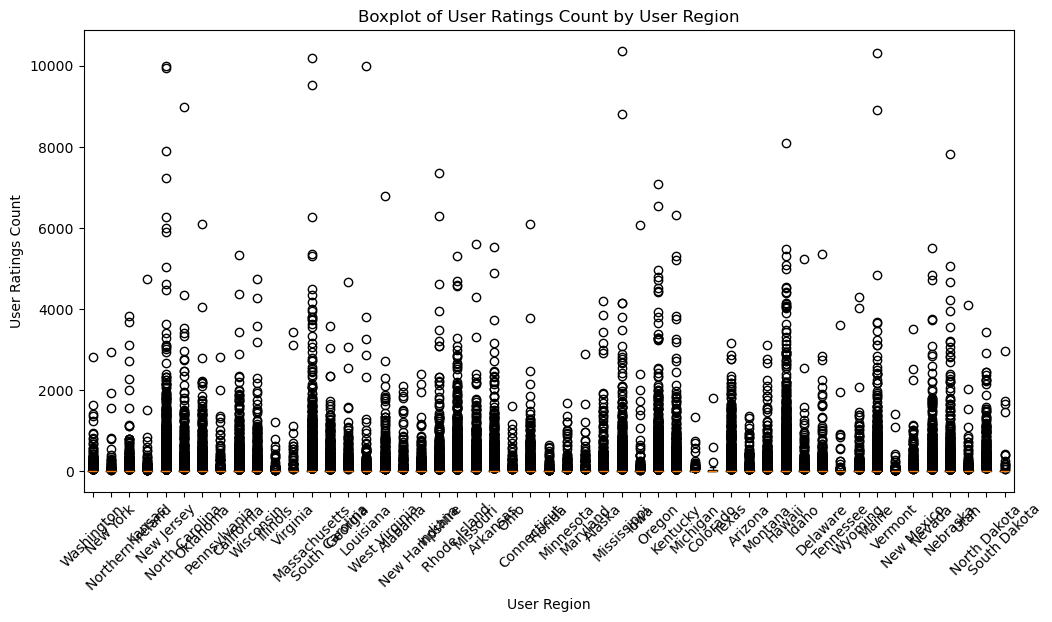

In [46]:
grouped_data = [group['user_ratings_count'].dropna() 
                for _, group in df_ba_users.groupby('user_region')]

region_labels = df_ba_users['user_region'].dropna().unique()


plt.figure(figsize=(12, 6))
plt.boxplot(grouped_data, labels=region_labels)
plt.title('Boxplot of User Ratings Count by User Region')
plt.xlabel('User Region')
plt.ylabel('User Ratings Count')
plt.xticks(rotation=45)


In [47]:
df_ba_users.columns

Index(['user_ratings_count', 'user_reviews_count', 'user_id', 'user_name',
       'user_created_date', 'user_country', 'user_region', 'user_country_code',
       'user_country_region'],
      dtype='object')

/var/folders/g1/hq_ymt617dz0gqxr47f1v5p40000gn/T/ipykernel_53704/2632787279.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ipa_ratings['rating_interval'] = pd.cut(ipa_ratings['ratings_average'], bins=bins, include_lowest=True)


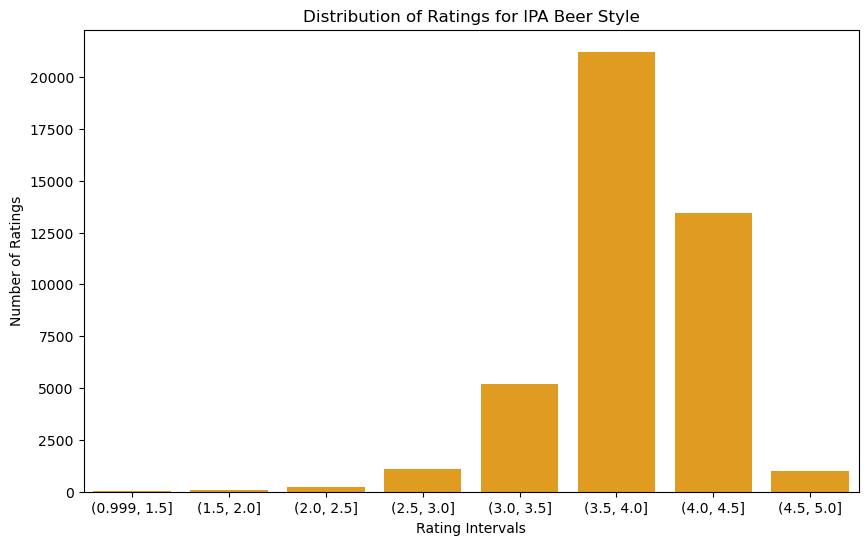

In [48]:
ipa_ratings = df_ba_beers[df_ba_beers['beer_global_style'] == 'India Pale Ale']
bins = [1, 1.5, 2, 2.5, 3, 3.5, 4, 4.5, 5]
ipa_ratings.columns
ipa_ratings['rating_interval'] = pd.cut(ipa_ratings['ratings_average'], bins=bins, include_lowest=True)


ipa_rating_distribution = ipa_ratings['rating_interval'].value_counts().sort_index()

plt.figure(figsize=(10, 6))
sns.barplot(x=ipa_rating_distribution.index.astype(str), y=ipa_rating_distribution.values, color="orange")
plt.title("Distribution of Ratings for IPA Beer Style")
plt.xlabel("Rating Intervals")
plt.ylabel("Number of Ratings")
plt.show()

In [49]:
Q_20 = np.quantile(ipa_ratings['ratings_average'].dropna(), 0.20)
Q_80 = np.quantile(ipa_ratings['ratings_average'].dropna(), 0.80)

print(f'The quantiles are {Q_20} and {Q_80}')

The quantiles are 3.58 and 4.15


<Axes: xlabel='beer_global_style', ylabel='ratings_average'>

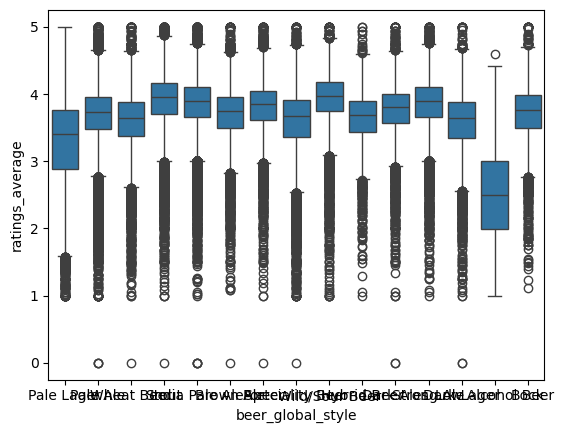

In [50]:
sns.boxplot(df_ba_beers.dropna(subset=['ratings_average']), x="beer_global_style", y='ratings_average')

In [51]:
quantiles = df_ba_beers.dropna(subset=['ratings_average']).groupby('beer_global_style')['ratings_average'].quantile([0.25, 0.75])

quantiles = quantiles.unstack(level=1).reset_index()
quantiles.columns = ['beer_global_style', 'Q1', 'Q3']

print(quantiles)


   beer_global_style     Q1    Q3
0               Bock  3.500  3.99
1          Brown Ale  3.500  3.95
2          Dark Ales  3.570  4.00
3         Dark Lager  3.350  3.88
4        Hybrid Beer  3.430  3.90
5     India Pale Ale  3.660  4.10
6   Low Alcohol Beer  1.995  3.00
7           Pale Ale  3.480  3.95
8         Pale Lager  2.890  3.76
9             Porter  3.620  4.05
10   Speciality Beer  3.360  3.91
11             Stout  3.700  4.17
12        Strong Ale  3.660  4.10
13        Wheat Beer  3.370  3.88
14    Wild/Sour Beer  3.740  4.18


In [52]:
df_ba_ratings[['user_id', 'beer_past_ratings_count', 'beer_past_ratings_average', 'beer_global_style', 'user_beer_style_past_ratings_count', 'user_beer_style_past_ratings_average']]

,user_id,beer_past_ratings_count,beer_past_ratings_average,beer_global_style,user_beer_style_past_ratings_count,user_beer_style_past_ratings_average
0,nmann08.184925,0,NaN,Pale Lager,324,3.183796
1,stjamesgate.163714,3,3.903333,Pale Ale,4,3.765000
2,mdagnew.19527,2,3.990000,Pale Ale,30,4.018667
3,helloloser12345.10867,1,4.000000,Pale Ale,2,3.815000
4,cypressbob.3708,0,NaN,Pale Ale,44,3.501818
...,...,...,...,...,...,...
8393027,jaluria.31362,2,2.170000,Pale Ale,38,3.864211
8393028,dithyramb.4413,1,1.540000,Pale Ale,95,3.730000
8393029,manekineko.2654,0,NaN,Pale Ale,65,3.668615
8393030,redsox1539.683632,1,3.000000,Brown Ale,1,3.500000


In [53]:
def new_mean(count, average_mean, new_rating):
    return (count * average_mean + new_rating) / (count + 1)

In [54]:
df_sorted = df_ba_ratings.sort_values(by='user_beer_style_past_ratings_count', ascending=False)
max_rating_idx = df_sorted.groupby(['user_id', 'beer_global_style', 'rating', 'user_beer_style_past_ratings_average'])['user_beer_style_past_ratings_count'].idxmax()

user_and_global_style = df_ba_ratings.loc[max_rating_idx, ['user_id', 'beer_global_style', 'rating', 'user_beer_style_past_ratings_average',
                                                           'user_beer_style_past_ratings_count']]
user_and_global_style = user_and_global_style.reset_index(drop=True)


In [14]:
user_and_global_style['user_beer_style_average'] = new_mean(user_and_global_style['user_beer_style_past_ratings_count'],
                                                            user_and_global_style['user_beer_style_past_ratings_average'],
                                                            user_and_global_style['rating']
                                                            )

In [15]:
user_and_global_style.head()

,user_id,beer_global_style,rating,user_beer_style_past_ratings_average,user_beer_style_past_ratings_count,user_beer_style_average
0,-----kiki-----.1000245,India Pale Ale,4.90,4.900,1,4.900000
1,-----kiki-----.1000245,Pale Lager,4.50,4.500,1,4.500000
2,---.940711,India Pale Ale,3.65,3.715,2,3.693333
3,---.940711,India Pale Ale,3.78,3.780,1,3.780000
4,---.940711,Wheat Beer,5.00,5.000,1,5.000000


In [145]:
user_rating_per_region = pd.merge(df_ba_users, user_and_global_style, on='user_id', how='inner')

In [55]:
df_users_simple = df_ba_users[['user_id', 'user_country_region', 'user_ratings_count']]

In [58]:
df_rating_simple = df_ba_ratings[['user_id', 'rating', 'beer_global_style', 'user_beer_style_past_ratings_count', 'user_beer_style_past_ratings_average']]

In [62]:
df_rating_per_region = df_rating_simple.merge(df_users_simple, on='user_id', how='left').dropna()

In [63]:
df_rating_per_region

,user_id,rating,beer_global_style,user_beer_style_past_ratings_count,user_beer_style_past_ratings_average,user_country_region,user_ratings_count
0,nmann08.184925,2.88,Pale Lager,324,3.183796,North America,7820
1,stjamesgate.163714,3.67,Pale Ale,4,3.765000,North America,2521
2,mdagnew.19527,3.73,Pale Ale,30,4.018667,Western Europe,1797
3,helloloser12345.10867,3.98,Pale Ale,2,3.815000,Western Europe,31
4,cypressbob.3708,4.00,Pale Ale,44,3.501818,Western Europe,604
...,...,...,...,...,...,...,...
8389033,ecoboy.1641,3.18,Pale Ale,39,3.740769,North America,162
8389034,jaluria.31362,3.80,Pale Ale,38,3.864211,North America,334
8389035,dithyramb.4413,2.80,Pale Ale,95,3.730000,North America,510
8389036,manekineko.2654,1.54,Pale Ale,65,3.668615,North America,428


In [68]:
df_rating_per_region['user_beer_style_present_average'] = new_mean(df_rating_per_region['user_beer_style_past_ratings_count'],
                                                                   df_rating_per_region['user_beer_style_past_ratings_average'],
                                                                   df_rating_per_region['rating'])

In [78]:
df_rating_per_region['user_ratings_count'] = df_rating_per_region['user_ratings_count'] + 1

In [100]:
df_rating_per_region.drop(columns='user_beer_style_past_ratings_average').drop(columns='region_count')

,user_id,rating,beer_global_style,user_beer_style_past_ratings_count,user_country_region,user_ratings_count,user_beer_style_present_average
0,nmann08.184925,2.88,Pale Lager,324,North America,7821,3.182862
1,stjamesgate.163714,3.67,Pale Ale,4,North America,2522,3.746000
2,mdagnew.19527,3.73,Pale Ale,30,Western Europe,1798,4.009355
3,helloloser12345.10867,3.98,Pale Ale,2,Western Europe,32,3.870000
4,cypressbob.3708,4.00,Pale Ale,44,Western Europe,605,3.512889
...,...,...,...,...,...,...,...
8389033,ecoboy.1641,3.18,Pale Ale,39,North America,163,3.726750
8389034,jaluria.31362,3.80,Pale Ale,38,North America,335,3.862564
8389035,dithyramb.4413,2.80,Pale Ale,95,North America,511,3.720313
8389036,manekineko.2654,1.54,Pale Ale,65,North America,429,3.636364


<Axes: xlabel='user_country_region', ylabel='user_beer_style_present_average'>

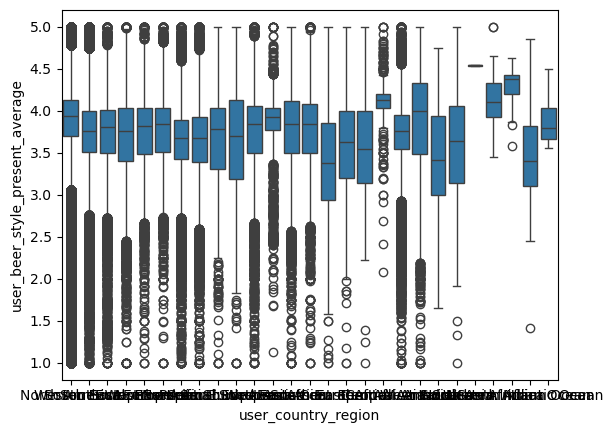

In [95]:
sns.boxplot(df_rating_per_region, x='user_country_region', y='user_beer_style_present_average')

In [71]:
weighted_average = df_rating_per_region.groupby('user_country_region').apply(lambda x: (x['user_beer_style_present_average'] * x['user_beer_style_past_ratings_count']).sum() /
              x['user_beer_style_past_ratings_count'].sum())

/var/folders/g1/hq_ymt617dz0gqxr47f1v5p40000gn/T/ipykernel_53704/3300771649.py:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  weighted_average = df_rating_per_region.groupby('user_country_region').apply(lambda x: (x['user_beer_style_present_average'] * x['user_beer_style_past_ratings_count']).sum() /


In [73]:
weighted_average = weighted_average.reset_index(name='weighted_average')

In [88]:
region_count = df_rating_per_region.groupby('user_country_region')['user_ratings_count'].sum()
region_count = region_count.reset_index(name='region_count')

In [90]:
average_per_region = weighted_average.merge(region_count, on='user_country_region', how='left')

In [101]:
df_rating_per_region

,user_id,rating,beer_global_style,user_beer_style_past_ratings_count,user_beer_style_past_ratings_average,user_country_region,user_ratings_count,user_beer_style_present_average,region_count
0,nmann08.184925,2.88,Pale Lager,324,3.183796,North America,7821,3.182862,NaN
1,stjamesgate.163714,3.67,Pale Ale,4,3.765000,North America,2522,3.746000,NaN
2,mdagnew.19527,3.73,Pale Ale,30,4.018667,Western Europe,1798,4.009355,NaN
3,helloloser12345.10867,3.98,Pale Ale,2,3.815000,Western Europe,32,3.870000,NaN
4,cypressbob.3708,4.00,Pale Ale,44,3.501818,Western Europe,605,3.512889,NaN
...,...,...,...,...,...,...,...,...,...
8389033,ecoboy.1641,3.18,Pale Ale,39,3.740769,North America,163,3.726750,NaN
8389034,jaluria.31362,3.80,Pale Ale,38,3.864211,North America,335,3.862564,NaN
8389035,dithyramb.4413,2.80,Pale Ale,95,3.730000,North America,511,3.720313,NaN
8389036,manekineko.2654,1.54,Pale Ale,65,3.668615,North America,429,3.636364,NaN


In [122]:
df_beerstyle_count = df_rating_per_region.groupby('beer_global_style')['user_beer_style_past_ratings_count'].sum()
df_beerstyle_count = df_beerstyle_count.reset_index(name='total_count')

In [123]:
df_beerstyle_count

,beer_global_style,total_count
0,Bock,2276858
1,Brown Ale,5013954
2,Dark Ales,11004900
3,Dark Lager,4992701
4,Hybrid Beer,297982
5,India Pale Ale,219985413
6,Pale Ale,174126068
7,Pale Lager,24653089
8,Porter,10201661
9,Speciality Beer,14485925


In [118]:
df_region_style_count = df_rating_per_region.groupby(['user_country_region', 'beer_global_style'])['user_ratings_count'].sum()
df_region_style_count = df_region_style_count.reset_index(name='count_per_region')

In [119]:
df_region_style_count

,user_country_region,beer_global_style,count_per_region
0,Antarctica,Bock,129
1,Antarctica,Brown Ale,443
2,Antarctica,Dark Ales,202
3,Antarctica,Dark Lager,1154
4,Antarctica,Hybrid Beer,173
...,...,...,...
337,Western Europe,Speciality Beer,3595028
338,Western Europe,Stout,11638404
339,Western Europe,Strong Ale,8868119
340,Western Europe,Wheat Beer,5026821


In [124]:
final = df_region_style_count.merge(region_count, on='user_country_region', how='left')

In [133]:
final2 = final.merge(df_beerstyle_count, on='beer_global_style', how='left')
final2['proportion'] = final2['count_per_region'] / final2['total_count']

In [134]:
final2

,user_country_region,beer_global_style,count_per_region,region_count,total_count,proportion
0,Antarctica,Bock,129,9236,2276858,0.000057
1,Antarctica,Brown Ale,443,9236,5013954,0.000088
2,Antarctica,Dark Ales,202,9236,11004900,0.000018
3,Antarctica,Dark Lager,1154,9236,4992701,0.000231
4,Antarctica,Hybrid Beer,173,9236,297982,0.000581
...,...,...,...,...,...,...
337,Western Europe,Speciality Beer,3595028,106843759,14485925,0.248174
338,Western Europe,Stout,11638404,106843759,99047035,0.117504
339,Western Europe,Strong Ale,8868119,106843759,35610368,0.249032
340,Western Europe,Wheat Beer,5026821,106843759,10167904,0.494381


In [140]:
wheatbeer_proportion = final2[final2['beer_global_style'] == 'Wheat Beer'][['user_country_region','proportion']]
wheatbeer_proportion.set_index('user_country_region')

,proportion
user_country_region,
Antarctica,0.000027
Central Africa,0.001183
Central America,0.217490
Central Asia,0.000182
Central Europe,0.018007
East Asia,0.047053
Eastern Africa,0.000156
Eastern Europe,0.023589
North America,38.158356


In [141]:
df_ba_ratings['dominant_style'] = df_ba_ratings.groupby('user_id')['beer_global_style'].transform(lambda x: x.mode()[0])

In [150]:
relationships = []
for group_style in df_ba_ratings['beer_global_style'].unique():
    group = df_ba_ratings[df_ba_ratings['dominant_style'] == group_style]
    group_users = group['user_id'].unique()
    group_mean  = group['rating'].mean()

    for target_style in df_ba_ratings['beer_global_style'].unique():
        style_ratings = df_ba_ratings[
            (df_ba_ratings['user_id'].isin(group_users)) &
            (df_ba_ratings['beer_global_style'] == target_style)
        ]['rating'] - group_mean
        
        if not style_ratings.empty:
            relationships.append({
                'group_style': group_style,
                'target_style': target_style,
                'len_group': len(group_users),
                'len_style_ratings': len(style_ratings)
            })
df_ba_relationships = pd.DataFrame(relationships)

In [153]:
beer_style_short_mapping = {
    "Pale Lager": "PL",
    "Pale Ale": "PA",
    "Wheat Beer": "WB",
    "Stout": "S",
    "India Pale Ale": "IPA",
    "Brown Ale": "BA",
    "Hybrid Beer": "HB",
    "Dark Ales": "DA",
    "Strong Ale": "SA",
    "Porter": "P",
    "Speciality Beer": "SB",
    "Wild/Sour Beer": "WSB",
    "Dark Lager": "DL",
    "Bock": "B"
}

In [154]:
df_ba_relationships["group_style"] = df_ba_relationships["group_style"].map(beer_style_short_mapping)
df_ba_relationships["target_style"] = df_ba_relationships["target_style"].map(beer_style_short_mapping)


In [156]:
df_ba_relationships.to_csv('df_ba_relationships.csv', encoding='utf-8', index=False)

In [158]:
df_rb_beers     = pd.read_csv('../data/rate_beer/beers.csv')
df_rb_breweries = pd.read_csv('../data/rate_beer/breweries.csv')
df_rb_users     = pd.read_csv('../data/rate_beer/users.csv')
df_rb_ratings   = pd.read_csv('../data/rate_beer/ratings.csv')

df_ba_beers     = pd.read_csv('../data/beer_advocate/beers.csv')
df_ba_breweries = pd.read_csv('../data/beer_advocate/breweries.csv')
df_ba_users     = pd.read_csv('../data/beer_advocate/users.csv')
df_ba_ratings   = pd.read_csv('../data/beer_advocate/ratings.csv')

Text(0, 0.5, 'Average rating (/5)')

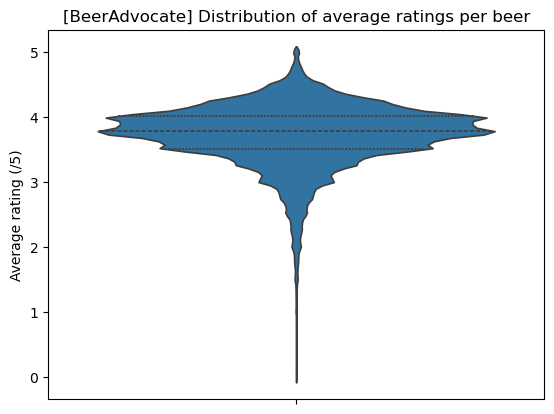

In [159]:
sns.violinplot(df_ba_beers["ratings_average"], inner="quart")
plt.title("[BeerAdvocate] Distribution of average ratings per beer")
plt.ylabel("Average rating (/5)")

Text(0, 0.5, 'Average rating (/5)')

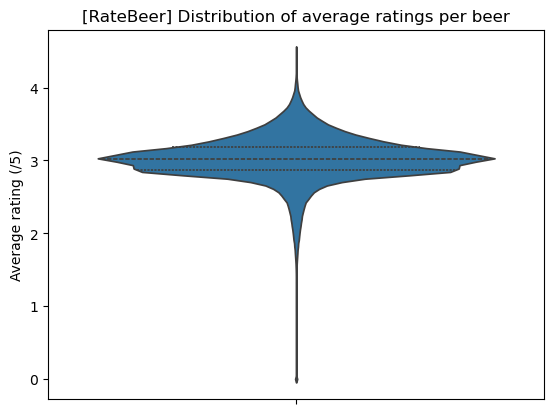

In [160]:
sns.violinplot(df_rb_beers["ratings_average"], inner="quart")
plt.title("[RateBeer] Distribution of average ratings per beer")
plt.ylabel("Average rating (/5)")

In [161]:
print(np.var(df_ba_beers["ratings_average"]), np.var(df_rb_beers["ratings_average"]))

0.22657780393500998 0.09257934799415617


# T-test to compare if the distributions are equal

In [164]:
stats.ttest_ind(a=df_ba_beers["ratings_average"].dropna(), b=df_rb_beers["ratings_average"].dropna(), equal_var=True)

TtestResult(statistic=709.676531357017, pvalue=0.0, df=635321.0)

#### Results :

We look at the null hypothesis $H_0$ : the distributions are equal against the alternative hypothesis $H_a$ : the distributions are not equal. By conducting a $t$--test, we obtain a $p$--value of $0.0$. Therefore we reject the null hypothesis $H_0$ at any significance level, concluding that the average ratings between *RateBeer* and *BeerAdvocate* are significantly different. Additionally the high $t$-statistic of $709.68$ supports this conclusion.

# Density Overlap


/var/folders/g1/hq_ymt617dz0gqxr47f1v5p40000gn/T/ipykernel_53704/1618201910.py:1: DeprecationWarning: Please import `gaussian_kde` from the `scipy.stats` namespace; the `scipy.stats.kde` namespace is deprecated and will be removed in SciPy 2.0.0.
  from scipy.stats.kde import gaussian_kde


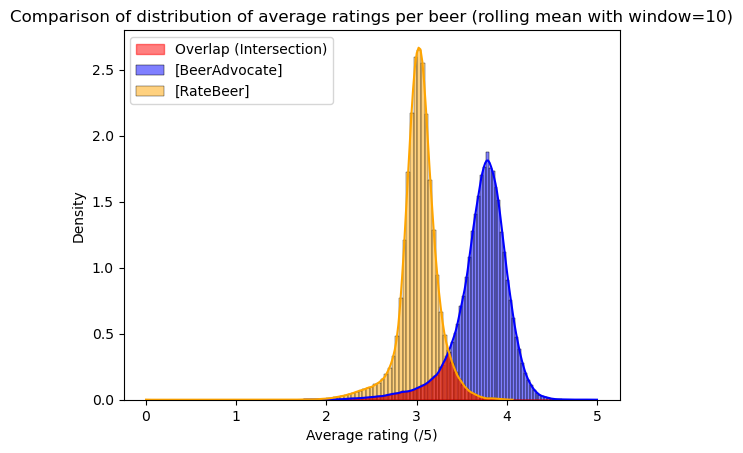

In [173]:
from scipy.stats.kde import gaussian_kde

ratings_average_rolling_ba = (
    df_ba_beers[df_ba_beers["ratings_average"].notna()]["ratings_average"]
    .rolling(10)
    .mean()[9:]
)
ratings_average_rolling_rb = (
    df_rb_beers[df_rb_beers["ratings_average"].notna()]["ratings_average"]
    .rolling(10)
    .mean()[9:]
)

sns.histplot(ratings_average_rolling_ba, bins=100, kde=True, stat="density", color="blue", label="[BeerAdvocate]")
sns.histplot(ratings_average_rolling_rb, bins=100, kde=True, stat="density", color="orange", label="[RateBeer]")

kde_ba = gaussian_kde(ratings_average_rolling_ba.dropna())
kde_rb = gaussian_kde(ratings_average_rolling_rb.dropna())

x = np.linspace(
    min(ratings_average_rolling_ba.min(), ratings_average_rolling_rb.min()),
    max(ratings_average_rolling_ba.max(), ratings_average_rolling_rb.max()),
    1000,
)

density_ba = kde_ba(x)
density_rb = kde_rb(x)

plt.fill_between(x, np.minimum(density_ba, density_rb), color="red", alpha=0.5, label="Overlap (Intersection)")
plt.title("Comparison of distribution of average ratings per beer (rolling mean with window=10)")
plt.legend()
plt.xlabel("Average rating (/5)")
plt.ylabel("Density")
plt.show()


#### Computation density overlap

In [170]:
from scipy.stats import gaussian_kde
import numpy as np

group1 = df_ba_beers["ratings_average"].dropna()
group2 = df_rb_beers["ratings_average"].dropna()

kde1 = gaussian_kde(group1)
kde2 = gaussian_kde(group2)

x = np.linspace(min(group1.min(), group2.min()), max(group1.max(), group2.max()), 1000)
density1 = kde1(x)
density2 = kde2(x)

overlap = np.trapz(np.minimum(density1, density2), x)

print(f"Density Overlap: {overlap}")

Density Overlap: 0.2764402041293574


#### Interpretation : 

The plot compares the distribution of average ratings for beers on BeerAdvocate (blue) and RateBeer (orange). The red area represents the overlap between the two distributions, which quantifies the similarity in their density.

The density overlap is calculated as the area under the minimum of the two density curves and is approximately $0.276$. This value indicates that only $27.6\%$ of the two distributions overlap, suggesting that the rating patterns on the two platforms are significantly different.

The visualization highlights both the individual characteristics of each platform's rating system and the limited shared density between the two, supporting the argument that the datasets are distinct.